In [1]:
## --- use API to download data-------------------------------------------------------------------- ##

# import library
import os
import numpy as np
import pandas as pd
import requests
import json
import prettytable

cd = os.getcwd()

In [4]:
# call area code references
states = list(pd.read_csv("BLS_LA_AREACODE.csv")["STATE"])
codes = list(pd.read_csv("BLS_LA_AREACODE.csv")["area_code"])

In [5]:
# make map of the area codes
states_codes = dict(zip(states, codes))

In [6]:
# for example
for state in states[1:4]:
    print(state, states_codes[state])

Alaska ST0200000000000
Arizona ST0400000000000
Arkansas ST0500000000000


In [5]:
## ----- auxiliary function get series id ----------------------------------------------
def get_tsid(state, metric = "unemployment"):
    # make series id base on state and measure code
    map_metric = {"unemployment" : "04", "employment" : "05"}
    ts_id = "LAU" + str(states_codes[state]) + map_metric[metric]
    return(ts_id)

In [6]:
# example
get_tsid("Connecticut", metric="unemployment")

'LAUST090000000000004'

In [7]:
## ----- function to download times series data in txt file -------------------------

def get_ts(state, metric="unemployment", start_year=2005, end_year=2016):
   
    # BLS API python codes
    headers = {'Content-type': 'application/json'}
    
    ts_id = get_tsid(state, metric) # call auxiliary function
    
    data = json.dumps({"seriesid": [ts_id],"startyear": str(start_year), "endyear":str(end_year)})
    p = requests.post('http://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)
    
    for series in json_data['Results']['series']:
        x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
        seriesId = series['seriesID']
        for item in series['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes=""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','

                if 'M01' <= period <= 'M12':
                    x.add_row([seriesId,year,period,value,footnotes[0:-1]])

        file_name = state + "_" + metric
        output = open(os.getcwd() + "/txt/" + file_name + ".txt", "w")
        output.write (x.get_string())
        output.close()

In [8]:
## ----- function to download times series data in txt file -------------------------

# ! can only download 9 years from 2005 to 2014 so have to download 2015 to 2016 again...
# essentially same functions as above "get_ts" but default years are recent years

def get_ts2(state, metric="unemployment", start_year=2015, end_year=2016):
       
    headers = {'Content-type': 'application/json'}
    
    ts_id = get_tsid(state, metric)
    
    data = json.dumps({"seriesid": [ts_id],"startyear": str(start_year), "endyear":str(end_year)})
    p = requests.post('http://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)
    
    for series in json_data['Results']['series']:
        x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
        seriesId = series['seriesID']
        for item in series['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes=""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','

                if 'M01' <= period <= 'M12':
                    x.add_row([seriesId,year,period,value,footnotes[0:-1]])

        # using different file name to not overwrite existing files
        file_name = state + "_" + metric + "_2015"
        output = open(os.getcwd() + "/txt/" + file_name + ".txt", "w")
        output.write (x.get_string())
        output.close()

In [9]:
# looping over each 10 states to obtain employment and unemployment statistics
# only can download one series and daily download limit on API 20 series per day
# "Request could not be serviced, as the daily threshold for total number of requests allocated to the user has been reached"

# for example
for state in states[0:9]:
    print(state)
    ## commented to avoid running to download on viewer's machine
    # get_ts(state, metric="unemployment") # unemployment statistics from 2005 to 2014
    # get_ts2(state, metric="unemployment") # 2015 to 2016
    # get_ts(state, metric="employment")  # employment statistics from 2005 to 2014
    # get_ts(state, metric="employment") # 2015 to 2016

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia


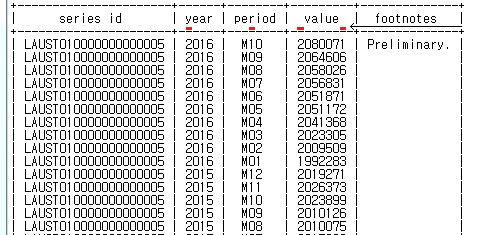

In [10]:
# sample image of the txt file for better understanding next functions
from IPython.display import Image
Image(cd+"/txtsample.jpg")

In [11]:
## ---  auxiliary function for creating csv file containing all 4 series for each state ---------------------------
## read downloaded unemployment series data in txt file 

def read_unemp(state):
    
    # initialize list to contain
    year, month, unemp = [], [], []
    
    # first open txt file containing 2016 to 2015 unemployment statistics
    file_15 = open(cd+"/txt/" + state + "_unemployment_2015.txt", "r")

    for i, lines in enumerate(file_15):
        # read index of the character "y" and the line length from the second line
        if i == 1:
            length = len(lines)
            index = str.index(lines, "y")
        # read years, months by reading characters starting from "y"
        # read unemployment statistics by reading from "y" and to the end of the line
        if i > 2:
            year.append((lines[index:index+4])) # 4 : e.g. 2015
            month.append(lines[index+9:index+11]) # 2 : e.g. 12
            unemp.append(lines[index+16:length-18]) # unkown length / longer than older file due to footnote
                
    # removing last line of dashes from "+ --------------- + " 
    unemp = unemp[0:len(unemp)-1]
    year = year[0:len(year)-1]
    month = month[0:len(month)-1]
    
    # open file containing 2014 to 2005 unemployment statistics and repeate same procedure
    file_05 = open(cd+"/txt/" + state + "_unemployment.txt", "r")
    
    for i, lines in enumerate(file_05):
        # just in case series_id "box" length different , shouldn't happend 
        if i == 1: 
            length = len(lines)
            index = str.index(lines, "y")
        if i > 2:
            year.append((lines[index:index+4])) # 4 : e.g. 2005
            month.append(lines[index+9:index+11]) # 2 : e.g. 12
            unemp.append(lines[index+16:length-15]) # unknown integer length

    unemp = unemp[0:len(unemp)-1]
    year = year[0:len(year)-1]
    month = month[0:len(month)-1]
    
    return unemp, year, month

In [12]:
## ---  auxiliary function for creating csv file containing all 4 series for each state ---------------------------
## read downloaded employment series data in txt file 

def read_emp(state):
    
    emp = [] # year, month identitcal
    
    # open file containing 2016 to 2015
    file_15 = open(cd+"/txt/" + state + "_employment_2015.txt", "r")

    for i, lines in enumerate(file_15):
        if i == 1:
            length = len(lines)
            index = str.index(lines, "y")
        if i > 2:
            emp.append(lines[index+16:length-18]) # unkown length
                
    emp = emp[0:len(emp)-1]

    # open file containing 2014 to 2005
    file_05 = open(cd+"/txt/" + state + "_employment.txt", "r")
    
    for i, lines in enumerate(file_05):
        if i == 1:
            length = len(lines)
            index = str.index(lines, "y")
        if i > 2:
            emp.append(lines[index+16:length-15]) # unknown length

    # removing last line of dash from "+ --------------- + " 
    emp = emp[0:len(emp)-1]

    return emp

In [ ]:
## --- function to create csv file containing all 4 series for each state ---------------------------
# using previous "read_emp" and "read_unemp" functions

def txt_to_csv(state):
    # initialize lists
    unemp, year, month, emp = [], [], [],[]
    # call auxiliary functions
    unemp, year, month = read_unemp(state)
    emp = read_emp(state)
    
    # create data frame
    df = pd.DataFrame( {'state' : state, "year" : year, "month" : month, 'unemployment' : unemp, 'employment': emp })
    # sort columns 
    df = df.reindex_axis(['state', "year", "month" ,'unemployment', 'employment'], axis=1)
    # sort index in reverse chronological order
    df.sort_index(ascending=False, inplace=True)
    # save file
    df.to_csv(cd+"/csv/" + state+".csv", index=False)
    pass

In [ ]:
# loop over states to run "txt_to_csv" function
# 52 *  4 txt files to 52 csv file
for state in states:
    txt_to_csv(state)

In [13]:
# for example
pd.read_csv(cd+"/csv/Alabama.csv").head(10)

,state,year,month,unemployment,employment
0,Alabama,2005,1,114319,2011219
1,Alabama,2005,2,115837,2014928
2,Alabama,2005,3,97042,2028597
3,Alabama,2005,4,83119,2045070
4,Alabama,2005,5,85864,2048188
5,Alabama,2005,6,107168,2048730
6,Alabama,2005,7,100411,2052713
7,Alabama,2005,8,97303,2053608
8,Alabama,2005,9,91681,2057174
9,Alabama,2005,10,91482,2078674


In [5]:
## --- save monthly unemployment rate in a single csv file ----------------------------------------------------

# for peiodogram and monthly rate with django
# instead of having 51 csv files containing BLS statistics in static folder
# aggregate to one csv file of monthly unemployment rates of 51 states

# auxiliary function to get monthly unemployment rate ( unemployment/(unemployment+employment) )

def get_urate_m(state):
    df = pd.read_csv(os.getcwd() + "/csv/" + state + ".csv")
    unemp = df["unemployment"]
    emp = df["employment"]
    urate = (unemp[0:143] + emp[0:143])
    rate = unemp/(unemp+emp)
    return(rate* 100)

def urate_csv():
    # do while loop for matrix row wise addition
    mat = get_urate_m("Alabama") # first row 
    for state in states[1:]:
        mat = np.vstack((mat,get_urate_m(state))) # row addition
        pass
    
    df = pd.DataFrame(mat) # data matrix to pandas dataframe
    df = pd.concat([df, pd.Series(states)], axis=1) # add new columns for index
    
    # setting state as index
    temp = [str(x) for x in list( range(142) )] # string list
    temp.append("state")
    # change column names
    df.columns = temp
    # finally setting "state" as index
    df.set_index("state", inplace = True)

    # date time as column names
    # 2005,2005,,,2015,,,,2016
    years = np.append( np.repeat(list(range(2005,2016)), 12, axis=0).astype(str), np.repeat(2016,10, axis=0).astype(str) ) 
    # 1,2,,,12,,,,,,10
    months = np.append( np.array(list(range(1,13)) * 12).astype(str), np.arange(1,11).astype(str) ) 
    # data from 2005-01 from 2016-10 
    
    colnames = []
    for i in range(len(years)):
        # 2015-10 not 2015-10-01 : no space for -01 in plot x tick
        # datetime make it anyways
        colnames.append( years[i] + "-" + months[i]) 

    df.columns = colnames
    
    # save as csv file
    df.to_csv("monthly_unemployment_rate.csv")

In [12]:
urate_csv()

In [11]:
# for example
pd.read_csv("monthly_unemployment_rate.csv", index_col="state").head(5)

,2005-1,2005-2,2005-3,2005-4,2005-5,2005-6,2005-7,2005-8,2005-9,2005-10,...,2016-1,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2016-10
state,,,,,,,,,,,,,,,,,,,,,
Alabama,5.378356,5.436404,4.565310,3.905621,4.023520,4.970922,4.663503,4.523804,4.266505,4.215457,...,6.306836,6.436245,6.142016,5.435878,5.728003,6.526390,5.776810,5.641062,5.698583,6.002953
Alaska,8.104835,8.208346,7.708349,7.048580,6.708267,6.804143,6.017947,5.705978,6.049783,6.438700,...,7.311384,7.709050,7.314394,6.917746,6.626005,6.714789,6.135101,5.907047,6.357032,6.345462
Arizona,4.912426,4.743833,4.711667,4.580473,4.449861,4.906315,4.956236,4.963311,4.790086,4.510493,...,5.327262,5.174946,5.074098,5.372228,5.477264,6.180346,6.344988,5.920487,5.605842,5.211655
Arkansas,6.115608,5.973942,5.311138,4.999600,5.261604,5.512063,5.687304,5.197703,4.860584,4.462096,...,4.692952,4.720677,4.041443,3.403931,3.823867,4.246487,4.328703,3.851761,3.946912,3.428273
California,6.151420,6.118821,5.868905,5.346143,5.028315,5.361389,5.522846,5.112898,5.097305,5.023991,...,5.842673,5.672922,5.558366,5.191005,4.734065,5.670003,5.865011,5.560537,5.292389,5.297379


In [17]:
## --- auxiliary function for aggregating monthly data to quarterly series ------------------------
## find quarterly BLS statistics by summing 3 elements in the list

def get_quarter(state, metric = "unemployment", endyear=2015):
    
    # read state level csv file
    df = pd.read_csv(cd + "/csv/" + state + ".csv")
    df = df[df['year'] <= endyear ]
    
    quarter = [] # initialize empty list
    
    # loop over and sum every 3 elements
    for i in list( range(0,len(df), 3) ) :
        quarter.append( sum(df[metric][i:i+3]) )
        pass
    
    return(quarter)

In [18]:
len(get_quarter("Alaska")) # (2015 - 2005 + 1) * 4 = 44

44

In [19]:
## --- function to aggreate state level csv files to a csv file containing quarterly statistics -------------------
## csv file structure  rows : states columns : quarterly statistics

def quarterly_csv(metric="unemployment", endyear=2015):
    # "do-while" loop like structure instead of initializing empty dataframe and adding rows and reorder rows and columns again
    
    mat = get_quarter("Alabama", metric, endyear) # first row 
    
    # loop over remaining states
    for state in states[1:]:
        # row wise addition / row bind
        mat = np.vstack((mat,get_quarter(state, metric, endyear))) 
        pass
    
    # convert numpy "matrix" to pandas dataframe
    df = pd.DataFrame(mat)
    # add new column of state names to be used as index
    df = pd.concat([df, pd.Series(states)], axis=1)  
    
    ## state as index
    # at this point, with df, both first and last columns have column name "0" 
    # temporary column names (cannot append to list(range(x,y))) for "state" as index 
    temp = [str(x) for x in list( range((endyear-2005+1)*4) )] 
    temp.append("state")
    # change column names
    df.columns = temp
    # finally setting "state" as index
    df.set_index("state", inplace = True)
   
    # assign real column names as numeric for easy plotting
    # e.g. 2005 Q1 as 2005.0 and 2005 Q2 and 2005.25 
    colnames = np.repeat(list(range(2005,2016)), 4, axis=0) + ([0,0.25,0.5,0.75] * 11) # element wise addition
    df.columns = colnames
    
    # save as csv file
    df.to_csv(cd + "/quarterly_" + metric + ".csv")
    
    pass

In [ ]:
# run functions to get quarterly csv
quarterly_csv(metric="unemployment")
quarterly_csv(metric="employment")

In [20]:
# for example
pd.read_csv("quarterly_unemployment.csv", index_col="state").head(5)

,2005.0,2005.25,2005.5,2005.75,2006.0,2006.25,2006.5,2006.75,2007.0,2007.25,...,2013.5,2013.75,2014.0,2014.25,2014.5,2014.75,2015.0,2015.25,2015.5,2015.75
state,,,,,,,,,,,,,,,,,,,,,
Alabama,327198,276151,289395,262062,274596,252667,282178,241465,266604,234976,...,487456,437953,494308,438967,456226,374850,393561,393192,411233,373632
Alaska,81336,70882,62371,70388,80502,70686,60789,65815,74812,67161,...,68225,74419,84694,77302,69347,69686,78168,71289,63769,69910
Arizona,406555,399868,427436,384383,384657,376424,406162,345434,343212,322217,...,750596,669252,643038,617402,669813,598149,587476,575589,613139,542073
Arkansas,228796,213145,214431,189204,218657,214677,215954,196755,229880,218910,...,288533,258971,272511,236423,237005,210977,238994,214916,203297,176603
California,3159635,2751123,2772182,2686013,2776169,2508652,2615382,2476040,2866242,2681885,...,5006221,4626290,4710038,4097217,4238987,3872350,3933148,3510563,3469114,3285052


In [21]:
## --- function to aggreate quarterly csv file to annual csv file -------------------
## csv file structure  rows : states columns : quarterly statistics

def annual_csv(metric="unemployment", endyear=2015):
    # read relevant quartery csv file
    qdata = pd.read_csv("quarterly_" + metric + ".csv")
    
    # sum every 4 quarters to get annual data
    mat = np.sum(qdata[qdata.columns[1:5]],axis=1) # first year (do-while loop)
    for i in range(5,44,4): # for remaining years
        # print(qdata[qdata.columns[i:i+4]].columns) # for checking
        annual = np.sum(qdata[qdata.columns[i:i+4]],axis=1) # annual data by summing 4 quarters
        mat = np.vstack((mat,annual)) # row wise addition / row bind
        pass
    
    # convert transpose of data matrix to pandas dataframe
    # looped over years so data matrix dimensions are 10 by 50 so need to take transpose
    df = pd.DataFrame(mat.T)
    
    # add new column of state names to be used as an index
    df = pd.concat([df, pd.Series(states)], axis=1)
    
    # new column names
    colnames = list(range(2005,2016))
    colnames.append("state")
    df.columns = colnames
    
    df.set_index("state", inplace = True) # set state as index
    
    df.to_csv("annual_" + metric + ".csv")

In [ ]:
# run functions to get annual csv
annual_csv("unemployment")
annual_csv("employment")

In [22]:
# for example
pd.read_csv("annual_unemployment.csv", index_col="state").head(5)

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
state,,,,,,,,,,,
Alabama,1154806,1050906,1037814,1476140,2859026,2777801,2547080,2077478,1881686,1764351,1571618
Alaska,284977,277792,266477,285893,334259,341964,333021,312788,303105,301029,283136
Arizona,1618242,1512677,1402790,2291516,3726399,3843016,3462565,3033288,2826318,2528402,2318277
Arkansas,845576,846043,872541,902882,1278143,1330101,1358020,1220171,1151723,956916,833810
California,11368953,10376243,11537882,15883696,24390812,26931910,25883601,23082941,20028302,16918592,14197877
